In [73]:
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.utils import resample
import re
import numpy as np

def load_data(success_path, failed_path):
    # Load only genuine logs
    success_df = pd.read_csv(success_path)
    failed_df = pd.read_csv(failed_path)
    
    # Clean and label
    success_df['label'] = 1  # LOGIN_SUCCESS
    failed_df['label'] = 0   # LOGIN_FAILED
    
    # Combine and shuffle
    df = pd.concat([success_df, failed_df]).sample(frac=1, random_state=42)
    
    # Basic normalization (preserve key patterns)
    def normalize(log):
        log = re.sub(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', '[IP]', log)
        log = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '[EMAIL]', log)
        return log
    
    df['normalized_log'] = df['Log'].apply(normalize)
    return df

In [70]:
pd.set_option('display.max_colwidth', 500)

In [59]:
from sklearn.model_selection import train_test_split

def create_datasets(df):
    # Verify labels are numeric
    assert df['label'].dtype in [int, np.int64], "Labels must be numeric"
    
    # Stratified split (simplified)
    train_df, test_df = train_test_split(
        df, test_size=0.2, stratify=df['label'], random_state=42
    )
    train_df, val_df = train_test_split(
        train_df, test_size=0.125, stratify=train_df['label'], random_state=42
    )
    
    # Convert to Dataset
    return DatasetDict({
        'train': Dataset.from_pandas(train_df),
        'validation': Dataset.from_pandas(val_df),
        'test': Dataset.from_pandas(test_df)
    })

In [60]:
from transformers import TrainingArguments, AutoModelForSequenceClassification
import torch
from torch import nn

# Custom loss function for class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = (1 - pt)**self.gamma * ce_loss
        if self.alpha is not None:
            loss = self.alpha[targets] * loss
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,  # Increased
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=3e-5,  # Adjusted
    weight_decay=0.01,
    eval_strategy='steps',
    eval_steps=100,
    save_strategy='steps',
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1_FAILED',  # Focus on minority class
    greater_is_better=True,
    fp16=True,
    logging_steps=50,
    report_to='none',
    gradient_accumulation_steps=2  # Helps with small batches
)

def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(
        "jackaduma/SecBERT",
        num_labels=3,
        ignore_mismatched_sizes=False  # Changed from True!
    )
    # Initialize classifier properly
    model.classifier.weight.data.normal_(mean=0.0, std=0.02)
    model.classifier.bias.data.zero_()
    return model

In [61]:
from transformers import Trainer, AutoTokenizer
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("jackaduma/SecBERT")

def tokenize_function(examples):
    tokenized = tokenizer(
        examples["normalized_log"],
        padding="max_length",
        truncation=True,
        max_length=128
    )
    # Add numeric labels to tokenized output
    tokenized["labels"] = examples["label"]  
    return tokenized

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    
    # Ensure labels are numeric
    if isinstance(labels[0], str):
        label_map = {"OTHER": 0, "LOGIN_FAILED": 1, "LOGIN_SUCCESS": 2}
        labels = np.array([label_map[l] for l in labels])
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average=None, labels=[0, 1, 2]
    )
    return {
        'precision_OTHER': precision[0],
        'recall_OTHER': recall[0],
        'f1_OTHER': f1[0],
        'precision_FAILED': precision[1],
        'recall_FAILED': recall[1],
        'f1_FAILED': f1[1],
        'precision_SUCCESS': precision[2],
        'recall_SUCCESS': recall[2],
        'f1_SUCCESS': f1[2],
    }

def fine_tune(dataset):
    # Tokenize datasets (now includes labels)
    tokenized_datasets = dataset.map(tokenize_function, batched=True)
    
    trainer = Trainer(
        model_init=model_init,
        args=training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    return trainer

In [62]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(trainer, dataset):
    # Tokenize test set (with labels)
    tokenized_test = dataset["test"].map(tokenize_function, batched=True)
    
    # Get predictions
    predictions = trainer.predict(tokenized_test)
    preds = np.argmax(predictions.predictions, axis=-1)
    
    # Get true labels (ensure numeric)
    true_labels = dataset["test"]["label"]
    if isinstance(true_labels[0], str):
        label_map = {"OTHER": 0, "LOGIN_FAILED": 1, "LOGIN_SUCCESS": 2}
        true_labels = [label_map[l] for l in true_labels]
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=['OTHER', 'LOGIN_FAILED', 'LOGIN_SUCCESS'],
                yticklabels=['OTHER', 'LOGIN_FAILED', 'LOGIN_SUCCESS'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    # Classification report
    print(classification_report(
        true_labels, preds,
        target_names=['OTHER', 'LOGIN_FAILED', 'LOGIN_SUCCESS']
    ))
    
    # K-fold validation (updated)
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=5)
    
    # Ensure df has numeric labels
    df = dataset["train"].to_pandas()
    if isinstance(df['label'].iloc[0], str):
        df['label'] = df['label'].map({"OTHER": 0, "LOGIN_FAILED": 1, "LOGIN_SUCCESS": 2})
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['label'])):
        print(f"\nFold {fold + 1}")
        fold_train = Dataset.from_pandas(df.iloc[train_idx])
        fold_val = Dataset.from_pandas(df.iloc[val_idx])
        
        fold_trainer = fine_tune(DatasetDict({
            'train': fold_train,
            'validation': fold_val,
            'test': fold_val  # Using val as test for fold evaluation
        }))
        evaluate_model(fold_trainer, DatasetDict({
            'test': fold_val
        }))

In [63]:
import json
from transformers import pipeline

def deploy_model(model_path, batch_size=32):
    # Load best model
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    
    # Create pipeline with batching
    classifier = pipeline(
        "text-classification",
        model=model,
        tokenizer=tokenizer,
        device=0 if torch.cuda.is_available() else -1,
        batch_size=batch_size
    )
    
    def predict_logs(log_lines):
        results = classifier(log_lines)
        return [{
            'label': result['label'],
            'score': result['score'],
            'log': log_lines[i]
        } for i, result in enumerate(results)]
    
    # Example quantization (PyTorch only)
    if torch.cuda.is_available():
        model = model.half()  # FP16 quantization
        
    return predict_logs

Map: 100%|██████████| 80/80 [00:00<00:00, 5677.09 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at jackaduma/SecBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at jackaduma/SecBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


Map: 100%|██████████| 80/80 [00:00<00:00, 5680.55 examples/s]


C:\Users\Tomas\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


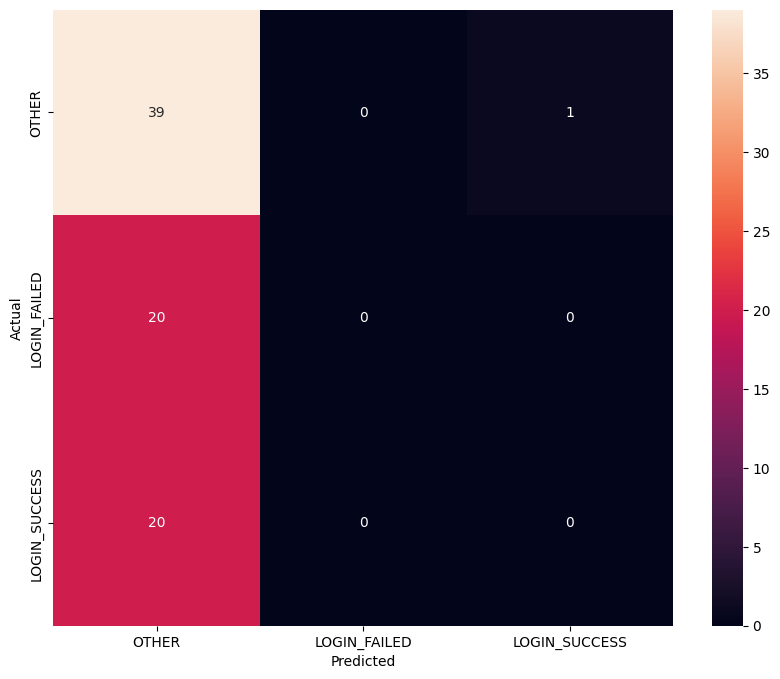

C:\Users\Tomas\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Tomas\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Tomas\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

               precision    recall  f1-score   support

        OTHER       0.49      0.97      0.66        40
 LOGIN_FAILED       0.00      0.00      0.00        20
LOGIN_SUCCESS       0.00      0.00      0.00        20

     accuracy                           0.49        80
    macro avg       0.16      0.33      0.22        80
 weighted avg       0.25      0.49      0.33        80


Fold 1


KeyError: 'Field "__index_level_0__" exists 2 times in schema'

In [64]:
if __name__ == "__main__":
    # 1. Prepare data
    df = load_and_label_data("failed_login_logs.csv", "failed_login_logs.csv")
    
    # 2. Create datasets
    dataset = create_datasets(df)
    
    # 3-4. Fine-tune modeldata/sample-logs/failed_login_logs.csv data/sample-logs/successful_login_logs.csv
    trainer = fine_tune(dataset)
    
    # 5. Evaluate
    evaluate_model(trainer, dataset)
    
    # 6. Save best model
    trainer.save_model("best_secbert_login_classifier")
    
    # 7. Example deployment
    predictor = deploy_model("best_secbert_login_classifier")
    sample_logs = ["Failed login attempt from 192.168.1.1", "User admin logged in successfully"]
    print(json.dumps(predictor(sample_logs), indent=2))

In [97]:
from sklearn.metrics import precision_recall_fscore_support

class LoginClassifier:
    def __init__(self, confidence_threshold=0.7):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.model = AutoModelForSequenceClassification.from_pretrained(
            "jackaduma/SecBERT",
            num_labels=2
        ).to(self.device)
        self.tokenizer = AutoTokenizer.from_pretrained("jackaduma/SecBERT")
        self.confidence_threshold = confidence_threshold

    def predict(self, logs):
        inputs = self.tokenizer(
            logs,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(self.device)

        with torch.no_grad():
            outputs = self.model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()

        results = []
        for i, log in enumerate(logs):
            pred_class = np.argmax(probs[i])
            confidence = probs[i][pred_class]

            if confidence < self.confidence_threshold:
                label = "OTHER"
            else:
                label = "LOGIN_SUCCESS" if pred_class == 1 else "LOGIN_FAILED"

            results.append({
                'log': log,
                'prediction': label,
                'confidence': float(confidence),
                'probabilities': {
                    'LOGIN_FAILED': float(probs[i][0]),
                    'LOGIN_SUCCESS': float(probs[i][1])
                }
            })
        return results

    def train(self, df):
        labels = df['label'].values

        encodings = self.tokenizer(
            df['normalized_log'].tolist(),
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )

        class LoginDataset(torch.utils.data.Dataset):
            def __init__(self, encodings, labels):
                self.encodings = encodings
                self.labels = labels

            def __getitem__(self, idx):
                return {
                    'input_ids': self.encodings['input_ids'][idx],
                    'attention_mask': self.encodings['attention_mask'][idx],
                    'labels': torch.tensor(self.labels[idx], dtype=torch.long)
                }

            def __len__(self):
                return len(self.labels)

        train_idx, val_idx = train_test_split(
            range(len(df)), 
            test_size=0.2, 
            stratify=labels
        )

        train_dataset = LoginDataset(
            {k: v[train_idx] for k, v in encodings.items()},
            labels[train_idx]
        )
        val_dataset = LoginDataset(
            {k: v[val_idx] for k, v in encodings.items()},
            labels[val_idx]
        )

        training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=3,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=64,
            eval_strategy="epoch",
            logging_dir='./logs',
            logging_steps=10,
            save_strategy="epoch",
            load_best_model_at_end=True,
            fp16=self.device.type == 'cuda'
        )

        def compute_metrics(eval_pred):
            logits, labels = eval_pred
            preds = np.argmax(logits, axis=-1)
            precision, recall, f1, _ = precision_recall_fscore_support(
                labels, preds, average=None, labels=[0, 1]
            )
            return {
                'f1_failed': float(f1[0]),
                'f1_success': float(f1[1]),
                'precision_failed': float(precision[0]),
                'precision_success': float(precision[1])
            }

        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics
        )

        trainer.train()

In [98]:
# Initialize
classifier = LoginClassifier()

# Load data (assuming you have this function)
df = load_data("successful_login_logs.csv", "failed_login_logs.csv")

# Train
classifier.train(df)  # Corrected to use the instance method

# Predict
logs = [
    "User admin logged in successfully",
    "Failed login attempt for user hacker",
    "System reboot initiated"
]
results = classifier.predict(logs)

for result in results:
    print(f"{result['prediction']} ({result['confidence']:.2f}): {result['log']}")
    print(f"Probabilities: {result['probabilities']}\n")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at jackaduma/SecBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


Epoch,Training Loss,Validation Loss,F1 Failed,F1 Success,Precision Failed,Precision Success
1,0.615100,0.451369,0.790698,0.756757,0.739130,0.823529
2,0.234300,0.088420,1.000000,1.000000,1.000000,1.000000
3,0.043000,0.039856,1.000000,1.000000,1.000000,1.000000


LOGIN_SUCCESS (0.80): User admin logged in successfully
Probabilities: {'LOGIN_FAILED': 0.20236435532569885, 'LOGIN_SUCCESS': 0.7976356148719788}

LOGIN_SUCCESS (0.86): Failed login attempt for user hacker
Probabilities: {'LOGIN_FAILED': 0.1399831771850586, 'LOGIN_SUCCESS': 0.8600167632102966}

OTHER (0.67): System reboot initiated
Probabilities: {'LOGIN_FAILED': 0.329149067401886, 'LOGIN_SUCCESS': 0.6708508729934692}



In [99]:
test_logs = [
        # Successful logins
        "May 18 09:05:23 ubuntu sshd[3456]: Accepted password for user1",
        '{"eventTime":"2025-05-18T09:20:55Z","eventName":"ConsoleLogin","responseElements":{"ConsoleLogin":"Success"}}',
        # Failed logins
        "2025-05-18T10:00:01Z Windows Server: EventID=4625 Authentication failed",
        '{"eventTime":"2025-05-18T10:25:56Z","responseElements":{"ConsoleLogin":"Failure"}}',
        # Other events
        '{"published":"2025-05-18T11:40:29Z","eventType":"user.repository.delete","outcome":{"result":"SUCCESS"}}',
        "2025-05-18 12:10:00 Fortinet FortiGate: system_reboot_initiated",
        # Edge cases
        "This is not a security log at all",
        "12424",
    ]

results = classifier.predict(test_logs)

for result in results:
    print(f"{result['prediction']} ({result['confidence']:.2f}): {result['log']}")
    print(f"Probabilities: {result['probabilities']}\n")

LOGIN_FAILED (0.85): May 18 09:05:23 ubuntu sshd[3456]: Accepted password for user1
Probabilities: {'LOGIN_FAILED': 0.8524448275566101, 'LOGIN_SUCCESS': 0.1475551873445511}

LOGIN_SUCCESS (0.75): {"eventTime":"2025-05-18T09:20:55Z","eventName":"ConsoleLogin","responseElements":{"ConsoleLogin":"Success"}}
Probabilities: {'LOGIN_FAILED': 0.2548333704471588, 'LOGIN_SUCCESS': 0.7451666593551636}

LOGIN_SUCCESS (0.93): 2025-05-18T10:00:01Z Windows Server: EventID=4625 Authentication failed
Probabilities: {'LOGIN_FAILED': 0.06566473096609116, 'LOGIN_SUCCESS': 0.9343352913856506}

OTHER (0.59): {"eventTime":"2025-05-18T10:25:56Z","responseElements":{"ConsoleLogin":"Failure"}}
Probabilities: {'LOGIN_FAILED': 0.5867300629615784, 'LOGIN_SUCCESS': 0.41326993703842163}

LOGIN_SUCCESS (0.96): {"published":"2025-05-18T11:40:29Z","eventType":"user.repository.delete","outcome":{"result":"SUCCESS"}}
Probabilities: {'LOGIN_FAILED': 0.0427621528506279, 'LOGIN_SUCCESS': 0.9572377800941467}

LOGIN_SUCCESS 